<a href="https://colab.research.google.com/github/Ronny5/TSAI_EVA_REPO/blob/master/S7_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms

from torchsummary import summary

from tqdm import tqdm

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline


Training a Classifier
=====================

This is it. You have seen how to define neural networks, compute loss and make
updates to the weights of the network.

Now you might be thinking,

What about data?
----------------

Generally, when you have to deal with image, text, audio or video data,
you can use standard python packages that load data into a numpy array.
Then you can convert this array into a ``torch.*Tensor``.

-  For images, packages such as Pillow, OpenCV are useful
-  For audio, packages such as scipy and librosa
-  For text, either raw Python or Cython based loading, or NLTK and
   SpaCy are useful

Specifically for vision, we have created a package called
``torchvision``, that has data loaders for common datasets such as
Imagenet, CIFAR10, MNIST, etc. and data transformers for images, viz.,
``torchvision.datasets`` and ``torch.utils.data.DataLoader``.

This provides a huge convenience and avoids writing boilerplate code.

For this tutorial, we will use the CIFAR10 dataset.
It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’,
‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of
size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

.. figure:: /_static/img/cifar10.png
   :alt: cifar10

   cifar10


Training an image classifier
----------------------------

We will do the following steps in order:

1. Load and normalizing the CIFAR10 training and test datasets using
   ``torchvision``
2. Define a Convolution Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data

1. Loading and normalizing CIFAR10
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Using ``torchvision``, it’s extremely easy to load CIFAR10.



### Calculating Ture Mean and STD for the CIFAR10 dataset (Train & Test combined)

In [2]:
def cifar10_mean_std():
    """Return the true mean of entire test and train dataset"""
    # simple transform
    simple_transforms = transforms.Compose([transforms.ToTensor(),])
    
    exp_train = torchvision.datasets.CIFAR10('./data', train=True, download=True, transform=simple_transforms)
    exp_test = torchvision.datasets.CIFAR10('./data', train=False, download=True, transform=simple_transforms)
    
    exp_tr_data = exp_train.data # train set
    exp_ts_data = exp_test.data # test set
    
    exp_data = np.concatenate((exp_tr_data,exp_ts_data),axis=0) # contatenate entire data
    
    exp_data = np.transpose(exp_data,(3,1,2,0)) # reshape to (60000, 32, 32, 3)
    
    norm_mean = (np.mean(exp_data[0])/255, np.mean(exp_data[1])/255, np.mean(exp_data[2])/255)
    norm_std   = (np.std(exp_data[0])/255, np.std(exp_data[1])/255, np.std(exp_data[2])/255)
    
    return(tuple(map(lambda x: np.round(x,2), norm_mean)), tuple(map(lambda x: np.round(x,2), norm_std)))

The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1].



In [3]:
# The output of torchvision datasets are PILImage images of range [0, 1]. We transform them to Tensors of normalized range [-1, 1].
# Define Transforms
norm_mean,norm_std = cifar10_mean_std() #  (0.49, 0.48, 0.45), (0.25, 0.24, 0.26)
train_transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize(norm_mean, norm_std)])
test_transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize(norm_mean, norm_std)])

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [4]:
# Extract and transform the data
train_set = torchvision.datasets.CIFAR10(root='./data', train=True,download=True, transform=train_transform)
test_set  = torchvision.datasets.CIFAR10(root='./data', train=False,download=True, transform=test_transform)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
# Targets -> ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
classes = train_set.classes

In [6]:
# Dataloader Arguments & Test/Train Dataloaders - Load part of ETL
SEED = 1
# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)
# For reproducibility
torch.manual_seed(SEED)
if cuda:
    torch.cuda.manual_seed(SEED)
    
# dataloader arguments 
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64, num_workers=1)

# train dataloader
train_loader = torch.utils.data.DataLoader(train_set, **dataloader_args)
# test dataloader
test_loader  = torch.utils.data.DataLoader(test_set, **dataloader_args)

CUDA Available? True


Let us show some of the training images, for fun.



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


size of image:  torch.Size([128, 3, 32, 32])
size of lables:  torch.Size([128])
torch.Size([3, 546, 274])
(3, 546, 274)
airplane   dog  deer  deer


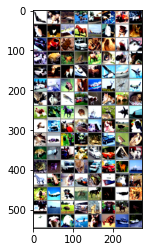

In [7]:
# functions to show an image

def imshow(img):
    img = img / 2 + 0.5    # unnormalize: which is image time the std then add the mean to get the pixel in 0 to 1 range.
    print(img.shape)
    npimg = img.numpy()
    print(npimg.shape)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
print("size of image: ",images.shape)
print("size of lables: ",labels.shape)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

2. Define a Convolution Neural Network
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Copy the neural network from the Neural Networks section before and modify it to
take 3-channel images (instead of 1-channel images as it was defined).



In [8]:
dropout_value = 0.1
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        # CONVOLUTION BLOCK 1
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value), # output_size = 32, RF = 3

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_value)
        ) # output_size = 32, RF = 5

        # TRANSITION BLOCK 1
        self.transblock1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=(1, 1), padding=1, bias=False), 
            # output_size = 34, RF = 5
            
            nn.MaxPool2d(2, 2, 1)
        ) # output_size = 18, RF = 6

        # CONVOLUTION BLOCK 2
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_value), # output_size = 18, RF = 10

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(128),
            nn.Dropout(dropout_value)
        ) # output_size = 18, RF = 14
        
        # TRANSITION BLOCK 2
        self.transblock2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=(1, 1), padding=1, bias=False), # output_size = 20, RF = 14
            nn.MaxPool2d(2, 2, 1)
        ) # output_size = 11, RF = 16
        
        # CONVOLUTION BLOCK 3 -> DWS and Dialted Conv
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), padding=1, groups=64, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_value), # output_size = 11, 24
            
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(1, 1), padding=1, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(128),
            nn.Dropout(dropout_value), # output_size = 11, 24
 
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), padding=1, dilation=2, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(128),
            nn.Dropout(dropout_value)
        ) # output_size = 9, RF = 40
        
        # TRANSITION BLOCK 3
        self.transblock3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=(1, 1), padding=1, bias=False), # output_size = 11, RF = 40
            nn.MaxPool2d(2, 2, 1) # output_size = 6, RF = 44 
        ) 
        
        # CONVOLUTION BLOCK 4
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(128),
            nn.Dropout(dropout_value), # output_size = 6, RF = 60

            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(256),
            nn.Dropout(dropout_value)
        ) # output_size = 6, RF = 76
        
        # OUTPUT BLOCK
        self.opblock= nn.Sequential(
            nn.AvgPool2d(kernel_size=6), # output_size = 1

            nn.Conv2d(in_channels=256, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10),
            # nn.ReLU(),
            # nn.Dropout(dropout_value)
        ) 


    def forward(self, x):
        x = self.convblock1(x)
        x = self.transblock1(x)
        x = self.convblock2(x)
        x = self.transblock2(x)
        x = self.convblock3(x)
        x = self.transblock3(x)
        x = self.convblock4(x)
        x = self.opblock(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [9]:
# from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
              ReLU-2           [-1, 32, 32, 32]               0
       BatchNorm2d-3           [-1, 32, 32, 32]              64
           Dropout-4           [-1, 32, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]          18,432
              ReLU-6           [-1, 64, 32, 32]               0
       BatchNorm2d-7           [-1, 64, 32, 32]             128
           Dropout-8           [-1, 64, 32, 32]               0
            Conv2d-9           [-1, 32, 34, 34]           2,048
        MaxPool2d-10           [-1, 32, 18, 18]               0
           Conv2d-11           [-1, 64, 18, 18]          18,432
             ReLU-12           [-1, 64, 18, 18]               0
      BatchNorm2d-13           [-1, 64, 18, 18]             128
          Dropout-14           [-1

3. Define a Loss function and optimizer
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Let's use a Classification Cross-Entropy loss and SGD with momentum.



In [10]:
# import torch.optim as optim

# criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

4. Train the network
^^^^^^^^^^^^^^^^^^^^

This is when things start to get interesting.
We simply have to loop over our data iterator, and feed the inputs to the
network and optimize.



In [11]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when we start your training loop, ideally we should zero out the gradients so that we do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Train Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Test Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [ ]:
# for epoch in range(2):  # loop over the dataset multiple times

#     running_loss = 0.0
#     for i, data in enumerate(train_loader, 0):
#         # get the inputs
#         inputs, labels = data.to(device)

#         # zero the parameter gradients
#         optimizer.zero_grad()

#         # forward + backward + optimize
#         outputs = net(inputs)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()

#         # print statistics
#         running_loss += loss.item()
#         if i % 2000 == 1999:    # print every 2000 mini-batches
#             print('[%d, %5d] loss: %.3f' %
#                   (epoch + 1, i + 1, running_loss / 2000))
#             running_loss = 0.0

# print('Finished Training')

Finished Training


In [12]:
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader)

  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH: 0


Loss=1.0080926418304443 Batch_id=390 Train Accuracy=48.70: 100%|██████████| 391/391 [01:03<00:00,  6.20it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 1.1087, Test Accuracy: 6100/10000 (61.00%)

EPOCH: 1


Loss=0.825715184211731 Batch_id=390 Train Accuracy=64.70: 100%|██████████| 391/391 [01:03<00:00,  6.16it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 1.0079, Test Accuracy: 6586/10000 (65.86%)

EPOCH: 2


Loss=0.8081408739089966 Batch_id=390 Train Accuracy=70.85: 100%|██████████| 391/391 [01:02<00:00,  6.26it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.8767, Test Accuracy: 7035/10000 (70.35%)

EPOCH: 3


Loss=0.6685292720794678 Batch_id=390 Train Accuracy=75.21: 100%|██████████| 391/391 [01:03<00:00,  6.17it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.7417, Test Accuracy: 7513/10000 (75.13%)

EPOCH: 4


Loss=0.6313077211380005 Batch_id=390 Train Accuracy=77.66: 100%|██████████| 391/391 [01:02<00:00,  6.23it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.7268, Test Accuracy: 7574/10000 (75.74%)

EPOCH: 5


Loss=0.6563390493392944 Batch_id=390 Train Accuracy=79.78: 100%|██████████| 391/391 [01:03<00:00,  6.15it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.6509, Test Accuracy: 7787/10000 (77.87%)

EPOCH: 6


Loss=0.45442357659339905 Batch_id=390 Train Accuracy=81.18: 100%|██████████| 391/391 [01:02<00:00,  6.24it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.6840, Test Accuracy: 7709/10000 (77.09%)

EPOCH: 7


Loss=0.5840237140655518 Batch_id=390 Train Accuracy=82.40: 100%|██████████| 391/391 [01:03<00:00,  6.15it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.6073, Test Accuracy: 8006/10000 (80.06%)

EPOCH: 8


Loss=0.3319315016269684 Batch_id=390 Train Accuracy=83.63: 100%|██████████| 391/391 [01:02<00:00,  6.25it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5547, Test Accuracy: 8066/10000 (80.66%)

EPOCH: 9


Loss=0.472106397151947 Batch_id=390 Train Accuracy=84.50: 100%|██████████| 391/391 [01:03<00:00,  6.17it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5608, Test Accuracy: 8100/10000 (81.00%)

EPOCH: 10


Loss=0.4716716408729553 Batch_id=390 Train Accuracy=88.19: 100%|██████████| 391/391 [01:02<00:00,  6.24it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5089, Test Accuracy: 8313/10000 (83.13%)

EPOCH: 11


Loss=0.5009031295776367 Batch_id=390 Train Accuracy=89.51: 100%|██████████| 391/391 [01:03<00:00,  6.17it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5234, Test Accuracy: 8332/10000 (83.32%)

EPOCH: 12


Loss=0.29236721992492676 Batch_id=390 Train Accuracy=90.16: 100%|██████████| 391/391 [01:02<00:00,  6.24it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5231, Test Accuracy: 8337/10000 (83.37%)

EPOCH: 13


Loss=0.2719131112098694 Batch_id=390 Train Accuracy=90.39: 100%|██████████| 391/391 [01:03<00:00,  6.15it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5275, Test Accuracy: 8369/10000 (83.69%)

EPOCH: 14


Loss=0.21594104170799255 Batch_id=390 Train Accuracy=90.44: 100%|██████████| 391/391 [01:02<00:00,  6.24it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5419, Test Accuracy: 8344/10000 (83.44%)

EPOCH: 15


Loss=0.32522040605545044 Batch_id=390 Train Accuracy=91.01: 100%|██████████| 391/391 [01:03<00:00,  6.16it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5397, Test Accuracy: 8352/10000 (83.52%)

EPOCH: 16


Loss=0.3299907445907593 Batch_id=390 Train Accuracy=91.27: 100%|██████████| 391/391 [01:02<00:00,  6.26it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5324, Test Accuracy: 8352/10000 (83.52%)

EPOCH: 17


Loss=0.1812286674976349 Batch_id=390 Train Accuracy=91.53: 100%|██████████| 391/391 [01:03<00:00,  6.17it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5385, Test Accuracy: 8385/10000 (83.85%)

EPOCH: 18


Loss=0.2082149088382721 Batch_id=390 Train Accuracy=91.55: 100%|██████████| 391/391 [01:02<00:00,  6.27it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5538, Test Accuracy: 8372/10000 (83.72%)

EPOCH: 19


Loss=0.20515799522399902 Batch_id=390 Train Accuracy=91.84: 100%|██████████| 391/391 [01:03<00:00,  6.18it/s]



Test set: Average loss: 0.5493, Test Accuracy: 8390/10000 (83.90%)



5. Test the network on the test data
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

We have trained the network for 2 passes over the training dataset.
But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network
outputs, and checking it against the ground-truth. If the prediction is
correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.



GroundTruth:    cat  ship  ship plane


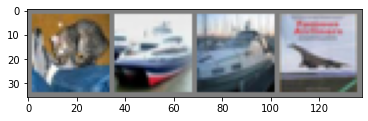

In [ ]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

Okay, now let us see what the neural network thinks these examples above are:



In [ ]:
outputs = net(images)

The outputs are energies for the 10 classes.
Higher the energy for a class, the more the network
thinks that the image is of the particular class.
So, let's get the index of the highest energy:



In [ ]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat  ship   car  ship


The results seem pretty good.

Let us look at how the network performs on the whole dataset.



In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 54 %


That looks waaay better than chance, which is 10% accuracy (randomly picking
a class out of 10 classes).
Seems like the network learnt something.

Hmmm, what are the classes that performed well, and the classes that did
not perform well:



In [ ]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 59 %
Accuracy of   car : 64 %
Accuracy of  bird : 45 %
Accuracy of   cat : 27 %
Accuracy of  deer : 37 %
Accuracy of   dog : 38 %
Accuracy of  frog : 73 %
Accuracy of horse : 65 %
Accuracy of  ship : 68 %
Accuracy of truck : 61 %
